# Test 2: SOTA LLMs (GPT-5, Gemini 3 Pro, Claude Sonnet 4.5)

This notebook tests if state-of-the-art LLMs have **bias towards resume writing style**:
- Do overstated resumes get higher seniority predictions?
- Do understated resumes get lower seniority predictions?
- Which words influence the model's decisions?

**Models tested:** GPT-5, Gemini 3 Pro, Claude Sonnet 4.5 (run in parallel via OpenRouter)

In [21]:
import os
import json
import urllib.request
import pandas as pd
import numpy as np
import re
from collections import Counter
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

# OpenRouter Config
OPENROUTER_URL = "https://openrouter.ai/api/v1/chat/completions"
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")

if not OPENROUTER_API_KEY:
    raise ValueError("Set OPENROUTER_API_KEY environment variable")

# Models to test
MODELS = {
    'gpt5': 'openai/gpt-5',
    'gemini3': 'google/gemini-3-pro-preview',
    'sonnet45': 'anthropic/claude-sonnet-4.5'
}

print(f"Testing {len(MODELS)} models: {list(MODELS.keys())}")

Testing 3 models: ['gpt5', 'gemini3', 'sonnet45']


In [22]:
# Load test data
df = pd.read_csv("../Test 2 Data/test2_resumes.csv")
print(f"Loaded {len(df)} resume sets (each has neutral, overstated, understated versions)")
print(f"Seniority distribution: {df['seniority'].value_counts().to_dict()}")

Loaded 120 resume sets (each has neutral, overstated, understated versions)
Seniority distribution: {'junior': 40, 'mid': 40, 'senior': 40}


In [23]:
PROMPT_TEMPLATE = """Classify this resume's seniority level. Respond with ONLY one word: junior, mid, or senior.

Resume:
{resume_text}

Seniority level:"""

def call_api(model_id, resume_text, max_retries=2):
    """Call OpenRouter API and return predicted label."""
    prompt = PROMPT_TEMPLATE.format(resume_text=resume_text[:8000])  # Truncate if too long
    
    for attempt in range(max_retries):
        try:
            payload = json.dumps({
                "model": model_id,
                "messages": [{"role": "user", "content": prompt}],
                # "max_tokens": 16
            }).encode("utf-8")
            
            req = urllib.request.Request(
                OPENROUTER_URL,
                data=payload,
                headers={
                    "Authorization": f"Bearer {OPENROUTER_API_KEY}",
                    "Content-Type": "application/json"
                }
            )
            
            with urllib.request.urlopen(req, timeout=120) as resp:
                result = json.loads(resp.read().decode("utf-8"))
            
            response = result["choices"][0]["message"]["content"].strip().lower()
            
            # Extract valid label
            if "junior" in response:
                return "junior"
            elif "mid" in response:
                return "mid"
            elif "senior" in response:
                return "senior"
            else:
                return "unknown"
                
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(1)
            else:
                return "error"
    
    return "error"

## Run Predictions (Parallel - 3 Models Simultaneously)

For each resume version, we call all 3 LLMs in parallel.

In [24]:
MAX_WORKERS = 15  # 3 models * 5 concurrent requests per model

# Build all tasks
tasks = []
styles = ['neutral', 'overstated', 'understated']

for idx, row in df.iterrows():
    true_seniority = row['seniority']
    for style in styles:
        resume_text = str(row[style])
        for model_name, model_id in MODELS.items():
            tasks.append({
                'idx': idx,
                'true_seniority': true_seniority,
                'style': style,
                'model': model_name,
                'model_id': model_id,
                'resume_text': resume_text
            })

print(f"Total API calls to make: {len(tasks)}")

Total API calls to make: 1080


In [25]:
def run_task(task):
    """Run a single prediction task."""
    pred = call_api(task['model_id'], task['resume_text'])
    return {
        'idx': task['idx'],
        'true_seniority': task['true_seniority'],
        'style': task['style'],
        'model': task['model'],
        'prediction': pred,
        'correct': pred == task['true_seniority'],
        'resume_text': task['resume_text']
    }

# Run all tasks in parallel
results = []
processed = 0
n = len(tasks)

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = {executor.submit(run_task, task): task for task in tasks}
    
    for future in as_completed(futures):
        try:
            result = future.result()
            results.append(result)
        except Exception as e:
            task = futures[future]
            results.append({
                'idx': task['idx'],
                'true_seniority': task['true_seniority'],
                'style': task['style'],
                'model': task['model'],
                'prediction': 'error',
                'correct': False,
                'resume_text': task['resume_text']
            })
        
        processed += 1
        if processed % 100 == 0 or processed == n:
            print(f"Processed {processed}/{n}")

results_df = pd.DataFrame(results)
print(f"\nTotal predictions: {len(results_df)}")
print(f"Errors: {(results_df['prediction'] == 'error').sum()}")

Processed 100/1080
Processed 200/1080
Processed 300/1080
Processed 400/1080
Processed 500/1080
Processed 600/1080
Processed 700/1080
Processed 800/1080
Processed 900/1080
Processed 1000/1080
Processed 1080/1080

Total predictions: 1080
Errors: 0


In [26]:
# Save results
results_df.to_csv("llm_predictions.csv", index=False)
print("Saved to llm_predictions.csv")

Saved to llm_predictions.csv


---
## Analysis 1: Accuracy by Style

Does writing style affect prediction accuracy?

In [27]:
# Filter out errors
valid_df = results_df[~results_df['prediction'].isin(['error', 'unknown'])].copy()
print(f"Valid predictions: {len(valid_df)}/{len(results_df)}")

print("\n" + "=" * 70)
print("ACCURACY BY STYLE AND MODEL")
print("=" * 70)

model_names = list(MODELS.keys())

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 40)
    model_df = valid_df[valid_df['model'] == model_name]
    
    for style in ['neutral', 'overstated', 'understated']:
        style_df = model_df[model_df['style'] == style]
        if len(style_df) > 0:
            acc = style_df['correct'].mean()
            print(f"  {style:<15}: {acc:.1%}")

Valid predictions: 1078/1080

ACCURACY BY STYLE AND MODEL

GPT5
----------------------------------------
  neutral        : 71.7%
  overstated     : 59.2%
  understated    : 89.2%

GEMINI3
----------------------------------------
  neutral        : 79.0%
  overstated     : 78.2%
  understated    : 92.5%

SONNET45
----------------------------------------
  neutral        : 99.2%
  overstated     : 98.3%
  understated    : 98.3%


---
## Analysis 2: Style Bias Detection

Key question: Do overstated resumes get predicted as higher seniority than they actually are?

In [28]:
# Map seniority to numeric
seniority_rank = {'junior': 0, 'mid': 1, 'senior': 2}
valid_df['true_rank'] = valid_df['true_seniority'].map(seniority_rank)
valid_df['pred_rank'] = valid_df['prediction'].map(seniority_rank)
valid_df['rank_diff'] = valid_df['pred_rank'] - valid_df['true_rank']

print("=" * 70)
print("PREDICTION BIAS BY STYLE (rank_diff: +ve = overestimate, -ve = underestimate)")
print("=" * 70)

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 50)
    model_df = valid_df[valid_df['model'] == model_name]
    
    print(f"{'Style':<15} {'Avg Rank Diff':<18} {'Overestimates':<15} {'Underestimates'}")
    for style in ['overstated', 'neutral', 'understated']:
        style_df = model_df[model_df['style'] == style]
        if len(style_df) > 0:
            avg_diff = style_df['rank_diff'].mean()
            over = (style_df['rank_diff'] > 0).sum()
            under = (style_df['rank_diff'] < 0).sum()
            print(f"{style:<15} {avg_diff:+.3f}{'':>12} {over:<15} {under}")

PREDICTION BIAS BY STYLE (rank_diff: +ve = overestimate, -ve = underestimate)

GPT5
--------------------------------------------------
Style           Avg Rank Diff      Overestimates   Underestimates
overstated      +0.408             49              0
neutral         +0.283             34              0
understated     +0.108             13              0

GEMINI3
--------------------------------------------------
Style           Avg Rank Diff      Overestimates   Underestimates
overstated      +0.218             26              0
neutral         +0.210             25              0
understated     +0.075             9               0

SONNET45
--------------------------------------------------
Style           Avg Rank Diff      Overestimates   Underestimates
overstated      +0.000             1               1
neutral         +0.008             1               0
understated     -0.017             0               2


In [29]:
print("=" * 70)
print("BIAS CHECK: Do overstated resumes get 'promoted'?")
print("=" * 70)

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 50)
    model_df = valid_df[valid_df['model'] == model_name]
    
    for true_level in ['junior', 'mid']:
        for style in ['overstated', 'neutral', 'understated']:
            subset = model_df[(model_df['true_seniority'] == true_level) & (model_df['style'] == style)]
            if len(subset) > 0:
                senior_preds = (subset['prediction'] == 'senior').sum()
                total = len(subset)
                pct = senior_preds / total * 100
                print(f"  {true_level.upper()} + {style:<12} → predicted SENIOR: {senior_preds}/{total} ({pct:.1f}%)")
        print()

BIAS CHECK: Do overstated resumes get 'promoted'?

GPT5
--------------------------------------------------
  JUNIOR + overstated   → predicted SENIOR: 0/40 (0.0%)
  JUNIOR + neutral      → predicted SENIOR: 0/40 (0.0%)
  JUNIOR + understated  → predicted SENIOR: 0/40 (0.0%)

  MID + overstated   → predicted SENIOR: 35/40 (87.5%)
  MID + neutral      → predicted SENIOR: 27/40 (67.5%)
  MID + understated  → predicted SENIOR: 6/40 (15.0%)


GEMINI3
--------------------------------------------------
  JUNIOR + overstated   → predicted SENIOR: 0/40 (0.0%)
  JUNIOR + neutral      → predicted SENIOR: 0/40 (0.0%)
  JUNIOR + understated  → predicted SENIOR: 0/40 (0.0%)

  MID + overstated   → predicted SENIOR: 26/39 (66.7%)
  MID + neutral      → predicted SENIOR: 24/39 (61.5%)
  MID + understated  → predicted SENIOR: 9/40 (22.5%)


SONNET45
--------------------------------------------------
  JUNIOR + overstated   → predicted SENIOR: 0/40 (0.0%)
  JUNIOR + neutral      → predicted SENIOR: 0/40

---
## Analysis 3: Same Person, Different Predictions?

For each person: do their 3 resume versions get different predictions?

In [30]:
print("=" * 70)
print("PREDICTION CONSISTENCY: Same person, different styles")
print("=" * 70)

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 50)
    model_df = valid_df[valid_df['model'] == model_name]
    
    inconsistent = 0
    style_changes = []
    
    for idx in df.index:
        person_df = model_df[model_df['idx'] == idx]
        if len(person_df) == 3:  # All 3 styles present
            preds = person_df.set_index('style')['prediction']
            if len(set(preds)) > 1:
                inconsistent += 1
                style_changes.append({
                    'idx': idx,
                    'true': df.loc[idx, 'seniority'],
                    'neutral': preds.get('neutral', '?'),
                    'overstated': preds.get('overstated', '?'),
                    'understated': preds.get('understated', '?')
                })
    
    total_valid = len(model_df['idx'].unique())
    print(f"Resumes with INCONSISTENT predictions: {inconsistent}/{total_valid} ({inconsistent/total_valid*100:.1f}%)")
    
    if style_changes:
        changes_df = pd.DataFrame(style_changes[:10])
        print("\nSample inconsistent predictions:")
        print(changes_df.to_string(index=False))

PREDICTION CONSISTENCY: Same person, different styles

GPT5
--------------------------------------------------
Resumes with INCONSISTENT predictions: 39/120 (32.5%)

Sample inconsistent predictions:
 idx   true neutral overstated understated
  16 junior     mid        mid      junior
  17 junior  junior        mid      junior
  20 junior  junior        mid         mid
  22 junior  junior        mid      junior
  28 junior  junior        mid      junior
  30 junior  junior        mid         mid
  35 junior  junior        mid      junior
  36 junior     mid        mid      junior
  37 junior  junior        mid      junior
  40    mid     mid     senior         mid

GEMINI3
--------------------------------------------------
Resumes with INCONSISTENT predictions: 20/120 (16.7%)

Sample inconsistent predictions:
 idx   true neutral overstated understated
  29 junior     mid     junior      junior
  42    mid  senior     senior         mid
  45    mid  senior     senior         mid
  48    

---
## Analysis 4: Word Influence Analysis

In [31]:
POWER_WORDS = {
    'spearheaded', 'revolutionized', 'pioneered', 'orchestrated', 'architected',
    'transformed', 'drove', 'championed', 'accelerated', 'maximized',
    'optimized', 'elevated', 'propelled', 'commanded', 'masterminded',
    'dramatically', 'significantly', 'substantially', 'exponentially', 'exceptionally',
    'outstanding', 'exceptional', 'remarkable', 'extraordinary', 'tremendous',
    'critical', 'crucial', 'vital', 'strategic', 'innovative',
    'enterprise', 'comprehensive', 'extensive', 'robust', 'cutting-edge',
    'visionary', 'influential', 'instrumental', 'pivotal', 'key'
}

HUMBLE_WORDS = {
    'helped', 'assisted', 'supported', 'contributed', 'participated',
    'aided', 'collaborated', 'worked', 'involved', 'engaged',
    'some', 'basic', 'minor', 'small', 'routine', 'standard', 'general',
    'occasional', 'limited', 'partial', 'modest', 'simple',
    'team', 'alongside', 'together', 'group', 'collective',
    'somewhat', 'relatively', 'fairly', 'adequately', 'sufficiently'
}

def count_words(text, word_set):
    words = re.findall(r'\b[a-z]+\b', str(text).lower())
    return sum(1 for w in words if w in word_set)

valid_df['power_count'] = valid_df['resume_text'].apply(lambda x: count_words(x, POWER_WORDS))
valid_df['humble_count'] = valid_df['resume_text'].apply(lambda x: count_words(x, HUMBLE_WORDS))

In [32]:
print("=" * 70)
print("WORD INFLUENCE: Power/Humble words in predictions")
print("=" * 70)

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 50)
    model_df = valid_df[valid_df['model'] == model_name]
    
    print(f"{'Prediction':<12} {'Avg Power Words':<18} {'Avg Humble Words'}")
    for pred in ['senior', 'mid', 'junior']:
        pred_df = model_df[model_df['prediction'] == pred]
        if len(pred_df) > 0:
            avg_power = pred_df['power_count'].mean()
            avg_humble = pred_df['humble_count'].mean()
            print(f"{pred:<12} {avg_power:.1f}{'':>14} {avg_humble:.1f}")

WORD INFLUENCE: Power/Humble words in predictions

GPT5
--------------------------------------------------
Prediction   Avg Power Words    Avg Humble Words
senior       11.3               7.4
mid          5.5               9.4
junior       6.4               7.7

GEMINI3
--------------------------------------------------
Prediction   Avg Power Words    Avg Humble Words
senior       10.7               7.6
mid          5.3               10.1
junior       7.5               7.3

SONNET45
--------------------------------------------------
Prediction   Avg Power Words    Avg Humble Words
senior       10.1               7.9
mid          8.6               8.6
junior       7.6               7.3


In [33]:
def get_word_freq(texts, word_set):
    counts = Counter()
    for text in texts:
        words = re.findall(r'\b[a-z]+\b', str(text).lower())
        for w in words:
            if w in word_set:
                counts[w] += 1
    return counts

print("=" * 70)
print("TOP POWER WORDS IN SENIOR vs JUNIOR PREDICTIONS")
print("=" * 70)

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 60)
    model_df = valid_df[valid_df['model'] == model_name]
    
    senior_texts = model_df[model_df['prediction'] == 'senior']['resume_text']
    junior_texts = model_df[model_df['prediction'] == 'junior']['resume_text']
    
    senior_words = get_word_freq(senior_texts, POWER_WORDS)
    junior_words = get_word_freq(junior_texts, POWER_WORDS)
    
    print("Power words in SENIOR predictions:", dict(senior_words.most_common(5)))
    print("Power words in JUNIOR predictions:", dict(junior_words.most_common(5)))

TOP POWER WORDS IN SENIOR vs JUNIOR PREDICTIONS

GPT5
------------------------------------------------------------
Power words in SENIOR predictions: {'strategic': 296, 'comprehensive': 227, 'key': 185, 'critical': 184, 'robust': 111}
Power words in JUNIOR predictions: {'key': 74, 'comprehensive': 51, 'critical': 50, 'strategic': 46, 'architected': 39}

GEMINI3
------------------------------------------------------------
Power words in SENIOR predictions: {'strategic': 269, 'comprehensive': 203, 'key': 175, 'critical': 168, 'robust': 106}
Power words in JUNIOR predictions: {'key': 106, 'comprehensive': 83, 'strategic': 79, 'critical': 77, 'architected': 59}

SONNET45
------------------------------------------------------------
Power words in SENIOR predictions: {'strategic': 161, 'comprehensive': 130, 'critical': 109, 'key': 96, 'robust': 75}
Power words in JUNIOR predictions: {'key': 108, 'comprehensive': 85, 'strategic': 85, 'critical': 79, 'architected': 59}


---
## Analysis 5: Misclassification Deep Dive

In [34]:
print("=" * 70)
print("MISCLASSIFICATION ANALYSIS")
print("=" * 70)

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 60)
    model_df = valid_df[valid_df['model'] == model_name]
    
    # Juniors predicted as Senior
    overpromoted = model_df[(model_df['true_seniority'] == 'junior') & (model_df['prediction'] == 'senior')]
    print(f"\nJuniors predicted as SENIOR: {len(overpromoted)}")
    if len(overpromoted) > 0:
        print(f"  Style breakdown: {overpromoted['style'].value_counts().to_dict()}")
        print(f"  Avg power words: {overpromoted['power_count'].mean():.1f}")
        print(f"  Avg humble words: {overpromoted['humble_count'].mean():.1f}")
    
    # Seniors predicted as Junior
    underpromoted = model_df[(model_df['true_seniority'] == 'senior') & (model_df['prediction'] == 'junior')]
    print(f"\nSeniors predicted as JUNIOR: {len(underpromoted)}")
    if len(underpromoted) > 0:
        print(f"  Style breakdown: {underpromoted['style'].value_counts().to_dict()}")
        print(f"  Avg power words: {underpromoted['power_count'].mean():.1f}")
        print(f"  Avg humble words: {underpromoted['humble_count'].mean():.1f}")

MISCLASSIFICATION ANALYSIS

GPT5
------------------------------------------------------------

Juniors predicted as SENIOR: 0

Seniors predicted as JUNIOR: 0

GEMINI3
------------------------------------------------------------

Juniors predicted as SENIOR: 0

Seniors predicted as JUNIOR: 0

SONNET45
------------------------------------------------------------

Juniors predicted as SENIOR: 0

Seniors predicted as JUNIOR: 0


---
## Summary Visualization

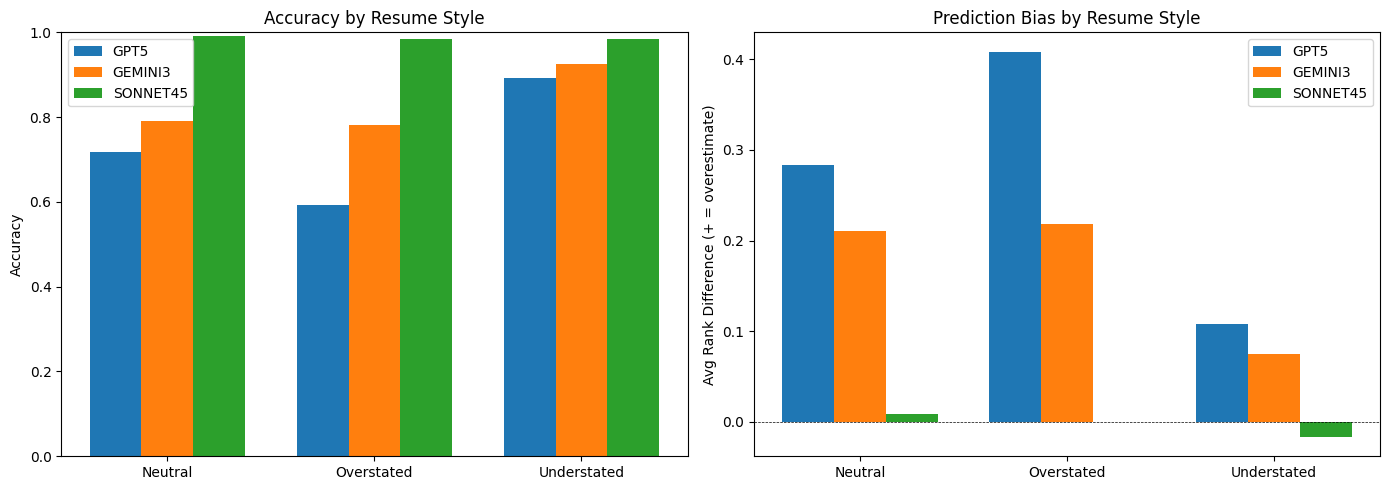

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

styles = ['neutral', 'overstated', 'understated']
x = np.arange(len(styles))
width = 0.25

# Plot 1: Accuracy by style
for i, model_name in enumerate(model_names):
    model_df = valid_df[valid_df['model'] == model_name]
    accs = [model_df[model_df['style'] == s]['correct'].mean() if len(model_df[model_df['style'] == s]) > 0 else 0 for s in styles]
    axes[0].bar(x + i*width, accs, width, label=model_name.upper())

axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy by Resume Style')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(['Neutral', 'Overstated', 'Understated'])
axes[0].legend()
axes[0].set_ylim(0, 1)

# Plot 2: Bias by style
for i, model_name in enumerate(model_names):
    model_df = valid_df[valid_df['model'] == model_name]
    diffs = [model_df[model_df['style'] == s]['rank_diff'].mean() if len(model_df[model_df['style'] == s]) > 0 else 0 for s in styles]
    axes[1].bar(x + i*width, diffs, width, label=model_name.upper())

axes[1].set_ylabel('Avg Rank Difference (+ = overestimate)')
axes[1].set_title('Prediction Bias by Resume Style')
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(['Neutral', 'Overstated', 'Understated'])
axes[1].legend()
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

---
## Cross-Model Comparison

In [36]:
print("=" * 70)
print("CROSS-MODEL COMPARISON")
print("=" * 70)

print(f"\n{'Model':<12} {'Neutral Acc':<14} {'Over Acc':<12} {'Under Acc':<12} {'Over Bias':<12} {'Under Bias'}")
print("-" * 75)

for model_name in model_names:
    model_df = valid_df[valid_df['model'] == model_name]
    
    neutral_acc = model_df[model_df['style'] == 'neutral']['correct'].mean()
    over_acc = model_df[model_df['style'] == 'overstated']['correct'].mean()
    under_acc = model_df[model_df['style'] == 'understated']['correct'].mean()
    over_bias = model_df[model_df['style'] == 'overstated']['rank_diff'].mean()
    under_bias = model_df[model_df['style'] == 'understated']['rank_diff'].mean()
    
    print(f"{model_name:<12} {neutral_acc:.1%}{'':>8} {over_acc:.1%}{'':>6} {under_acc:.1%}{'':>6} {over_bias:+.3f}{'':>6} {under_bias:+.3f}")

CROSS-MODEL COMPARISON

Model        Neutral Acc    Over Acc     Under Acc    Over Bias    Under Bias
---------------------------------------------------------------------------
gpt5         71.7%         59.2%       89.2%       +0.408       +0.108
gemini3      79.0%         78.2%       92.5%       +0.218       +0.075
sonnet45     99.2%         98.3%       98.3%       +0.000       -0.017


In [37]:
print("=" * 70)
print("FINAL SUMMARY")
print("=" * 70)

for model_name in model_names:
    model_df = valid_df[valid_df['model'] == model_name]
    
    print(f"\n{model_name.upper()}")
    print("-" * 50)
    
    # Accuracy
    neutral_acc = model_df[model_df['style'] == 'neutral']['correct'].mean()
    over_acc = model_df[model_df['style'] == 'overstated']['correct'].mean()
    under_acc = model_df[model_df['style'] == 'understated']['correct'].mean()
    
    print(f"Neutral accuracy:     {neutral_acc:.1%}")
    print(f"Overstated accuracy:  {over_acc:.1%}")
    print(f"Understated accuracy: {under_acc:.1%}")
    
    # Bias
    over_bias = model_df[model_df['style'] == 'overstated']['rank_diff'].mean()
    under_bias = model_df[model_df['style'] == 'understated']['rank_diff'].mean()
    
    print(f"\nOverstated bias:  {over_bias:+.3f} ({'overestimates' if over_bias > 0 else 'underestimates'})")
    print(f"Understated bias: {under_bias:+.3f} ({'overestimates' if under_bias > 0 else 'underestimates'})")
    
    # Inconsistency
    inconsistent = 0
    for idx in df.index:
        person_df = model_df[model_df['idx'] == idx]
        if len(person_df) == 3 and len(person_df['prediction'].unique()) > 1:
            inconsistent += 1
    total = len(model_df['idx'].unique())
    print(f"\nInconsistent predictions: {inconsistent}/{total} ({inconsistent/total*100:.1f}%)")

FINAL SUMMARY

GPT5
--------------------------------------------------
Neutral accuracy:     71.7%
Overstated accuracy:  59.2%
Understated accuracy: 89.2%

Overstated bias:  +0.408 (overestimates)
Understated bias: +0.108 (overestimates)

Inconsistent predictions: 39/120 (32.5%)

GEMINI3
--------------------------------------------------
Neutral accuracy:     79.0%
Overstated accuracy:  78.2%
Understated accuracy: 92.5%

Overstated bias:  +0.218 (overestimates)
Understated bias: +0.075 (overestimates)

Inconsistent predictions: 20/120 (16.7%)

SONNET45
--------------------------------------------------
Neutral accuracy:     99.2%
Overstated accuracy:  98.3%
Understated accuracy: 98.3%

Overstated bias:  +0.000 (underestimates)
Understated bias: -0.017 (underestimates)

Inconsistent predictions: 5/120 (4.2%)
